In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
snpcounts = {}

import gzip
with gzip.open('/mnt/d/exome/simulation_study/complex/chr22_complex_wgs.vcf.gz') as f:
    for line in f:
        line = line.decode('ASCII')
        if not line.startswith('#'):
            ls = line.split('\t')
            ac = 0
            for i in range(9, len(ls)):
                ac += ls[i].count('1')
            pos = int(ls[1])
            snpcounts[pos] = [pos, ac]

In [3]:
snpcounts2 = {}

import gzip
with gzip.open('/mnt/d/exome/simulation_study/simple/chr22_simple_wgs.vcf.gz') as f:
    for line in f:
        line = line.decode('ASCII')
        if not line.startswith('#'):
            ls = line.split('\t')
            ac = 0
            for i in range(9, len(ls)):
                ac += ls[i].count('1')
            pos = int(ls[1])
            snpcounts2[pos] = [pos, ac]

In [4]:
com= pd.DataFrame.from_dict(snpcounts, orient ='index', columns = ['position', 'k'])

In [5]:
sim = pd.DataFrame.from_dict(snpcounts2, orient ='index', columns = ['position', 'k'])

In [6]:
sim.loc[:, 'freq'] = sim['k']/7242 * 100
com.loc[:, 'freq'] = com['k']/7242 * 100 

In [7]:
sim.to_csv('/mnt/d/exome/wes_alleleAge/output/neutral_count_constant.csv', index = False)
com.to_csv('/mnt/d/exome/wes_alleleAge/output/neutral_count_expansion.csv', index = False)


In [9]:
## sim
rswes = pd.read_csv('../results/simple/relate/wes/chr22_wes_simple.mut', sep = ';')[['pos_of_snp', 'age_begin', 'age_end']]
rswes.loc[:, 'RelateAge'] = rswes[['age_begin', 'age_end']].mean(axis=1)
gswes = pd.read_csv('../results/simple/GEVA/wes/chr22_simple_wes_estimates.csv')[['PostMode', 'Position']]
tswes = pd.read_csv('../results/simple/tc/wes/half_simple_wes.csv')[['POS', 'TC']]
trueS = pd.read_csv('../simulation_study/simple/treeFiles/simple_true.txt', sep = '\t')

In [10]:
temp = rswes.merge(gswes, left_on = 'pos_of_snp', right_on = 'Position', how = 'outer').merge(tswes, left_on = 'pos_of_snp', right_on = 'POS', how = 'outer')
simpleEsts = temp.merge(sim, left_on ='pos_of_snp', right_on = 'position', how = 'outer').merge(trueS, left_on = 'position', right_on = 'position')

In [12]:
## complex
rcwes = pd.read_csv('../results/complex/relate/wes/chr22_wes_complex.mut', sep = ';')[['pos_of_snp', 'age_begin', 'age_end']]
rcwes.loc[:, 'RelateAge'] = rcwes[['age_begin', 'age_end']].mean(axis=1)
gcwes = pd.read_csv('../results/complex/GEVA/wes/chr22_complex_wes_estimates.csv')[['PostMode', 'Position']]
tcwes = pd.read_csv('../results/complex/tc/wes/half_complex_wes.csv')[['POS', 'TC']]
trueC = pd.read_csv('../simulation_study/complex/treeFiles/complex_true.txt', sep = '\t')

In [13]:
temp = rcwes.merge(gcwes, left_on = 'pos_of_snp', right_on = 'Position', how = 'outer').merge(tcwes, left_on = 'pos_of_snp', right_on = 'POS', how = 'outer')
complexEsts = temp.merge(com, left_on ='pos_of_snp', right_on = 'position', how = 'outer').merge(trueC, left_on = 'position', right_on = 'position')

62
66
73
98


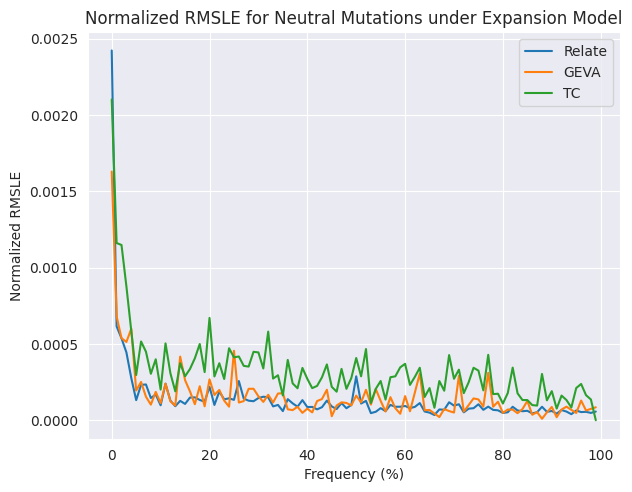

In [15]:
relVals = []
gevaVals = []
tcVals = []
gevak = []

for x in np.arange(0, 100, 1):
    tempTbl = complexEsts[(complexEsts['freq'] > x) & (complexEsts['freq'] <= x+1)]
    
    rl = tempTbl.dropna(subset=['RelateAge'])
    relVals.append(mean_squared_log_error(rl['mutationTime'], rl['RelateAge'], squared=False)/np.average(rl['mutationTime']))
    
    gl = tempTbl.dropna(subset=['PostMode'])
    try:
        gevaVals.append(mean_squared_log_error(gl['mutationTime'], gl['PostMode'], squared=False)/np.average(gl['mutationTime']))
        gevak.append(x)
    except:
        print(x)
    
    tl = tempTbl.dropna(subset=['TC'])
    tl = tl[tl['TC'] > 0]
    try:
        tcVals.append(mean_squared_log_error(tl['mutationTime'], tl['TC'], squared=False)/np.average(tl['mutationTime']))
    except:
        tcVals.append(0)
    
plt.plot(np.arange(0, 100), relVals, label = 'Relate')
plt.plot(gevak, gevaVals, label = 'GEVA')
plt.plot(np.arange(0, 100), tcVals, label = 'TC')
plt.legend()
plt.xlabel('Frequency (%)')
plt.ylabel('Normalized RMSLE')
plt.tight_layout()
#plt.savefig('../figures/norm_rmsle_complex.jpg', dpi=300)
plt.title('Normalized RMSLE for Neutral Mutations under Expansion Model')
plt.show()

67


Text(0.5, 1.0, 'Normalized RMSLE for Neutral Mutations under Constant Model')

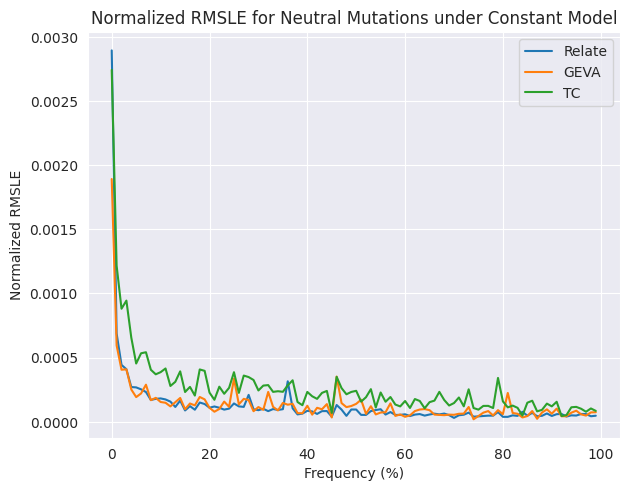

In [16]:
relVals = []
gevaVals = []
tcVals = []
gevak = []

for x in np.arange(0, 100, 1):
    tempTbl = simpleEsts[(simpleEsts['freq'] > x) & (simpleEsts['freq'] <= x+1)]
    
    rl = tempTbl.dropna(subset=['RelateAge'])
    relVals.append(mean_squared_log_error(rl['mutationTime'], rl['RelateAge'], squared=False)/np.average(rl['mutationTime']))
    
    gl = tempTbl.dropna(subset=['PostMode'])
    try:
        gevaVals.append(mean_squared_log_error(gl['mutationTime'], gl['PostMode'], squared=False)/np.average(gl['mutationTime']))
        gevak.append(x)
    except:
        print(x)
    
    tl = tempTbl.dropna(subset=['TC'])
    tl = tl[tl['TC'] > 0]
    tcVals.append(mean_squared_log_error(tl['mutationTime'], tl['TC'], squared=False)/np.average(tl['mutationTime']))
    
plt.plot(np.arange(0, 100), relVals, label = 'Relate')
plt.plot(gevak, gevaVals, label = 'GEVA')
plt.plot(np.arange(0, 100), tcVals, label = 'TC')
plt.legend()
plt.xlabel('Frequency (%)')
plt.ylabel('Normalized RMSLE')
plt.tight_layout()
#plt.savefig('../figures/norm_rmsle.jpg', dpi=300)
plt.title('Normalized RMSLE for Neutral Mutations under Constant Model')

0


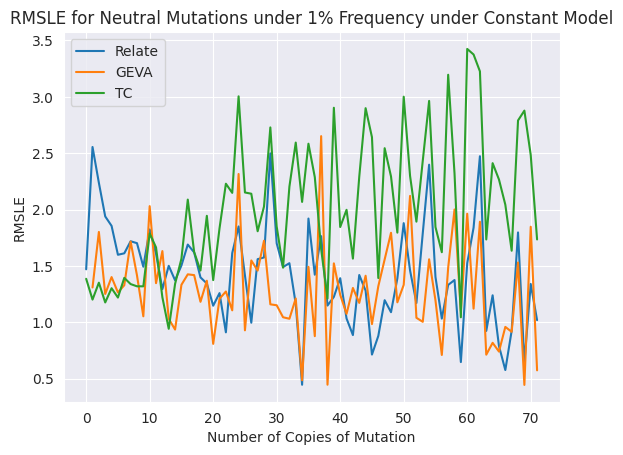

In [18]:
relVals = []
gevaVals = []
tcVals = []
gevak = []

for x in np.arange(0, 72, 1):
    tempTbl = simpleEsts[(simpleEsts['k'] > x) & (simpleEsts['k'] <= x+1)]
    
    rl = tempTbl.dropna(subset=['RelateAge'])
    relVals.append(mean_squared_log_error(rl['mutationTime'], rl['RelateAge'], squared=False))
    
    gl = tempTbl.dropna(subset=['PostMode'])
    try:
        gevaVals.append(mean_squared_log_error(gl['mutationTime'], gl['PostMode'], squared=False))
        gevak.append(x)
    except:
        print(x)
    
    tl = tempTbl.dropna(subset=['TC'])
    tl = tl[tl['TC'] > 0]
    tcVals.append(mean_squared_log_error(tl['mutationTime'], tl['TC'], squared=False))

plt.plot(np.arange(0, 72), relVals, label = 'Relate')
plt.plot(gevak, gevaVals, label = 'GEVA')
plt.plot(np.arange(0, 72), tcVals, label = 'TC')
plt.legend()
plt.xlabel('Number of Copies of Mutation')
plt.ylabel('RMSLE')
#plt.savefig('../figures/onePercentRMSLE.jpg', dpi=300)
plt.title('RMSLE for Neutral Mutations under 1% Frequency under Constant Model')
plt.show()

0


Text(0.5, 1.0, 'RMSLE of Neutral Mutations under 100 copies under Constant Model')

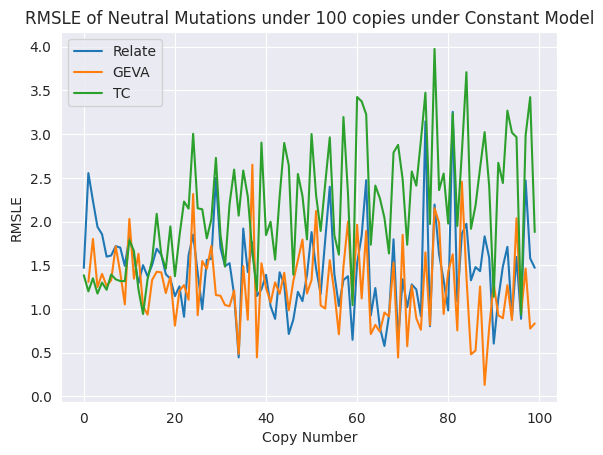

In [22]:
relVals = []
gevaVals = []
tcVals = []
gevak = []

for x in np.arange(0, 100, 1):
    tempTbl = simpleEsts[(simpleEsts['k'] > x) & (simpleEsts['k'] <= x+1)]
    
    rl = tempTbl.dropna(subset=['RelateAge'])
    relVals.append(mean_squared_log_error(rl['mutationTime'], rl['RelateAge'], squared=False))
    
    gl = tempTbl.dropna(subset=['PostMode'])
    try:
        gevaVals.append(mean_squared_log_error(gl['mutationTime'], gl['PostMode'], squared=False))
        gevak.append(x)
    except:
        print(x)
    
    tl = tempTbl.dropna(subset=['TC'])
    tl = tl[tl['TC'] > 0]
    tcVals.append(mean_squared_log_error(tl['mutationTime'], tl['TC'], squared=False))

plt.plot(np.arange(0, 100), relVals, label = 'Relate')
plt.plot(gevak, gevaVals, label = 'GEVA')
plt.plot(np.arange(0, 100), tcVals, label = 'TC')
plt.legend()
plt.xlabel('Copy Number')
plt.ylabel('RMSLE')
plt.title('RMSLE of Neutral Mutations under 100 copies under Constant Model')

67


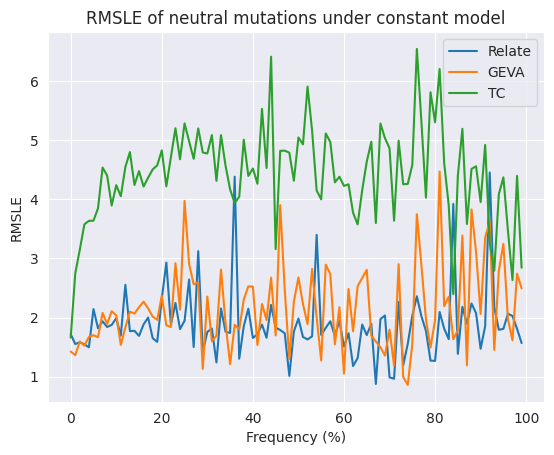

In [21]:
relVals = []
gevaVals = []
tcVals = []
gevak = []

for x in np.arange(0, 100, 1):
    tempTbl = simpleEsts[(simpleEsts['freq'] > x) & (simpleEsts['freq'] <= x+1)]
    
    rl = tempTbl.dropna(subset=['RelateAge'])
    relVals.append(mean_squared_log_error(rl['mutationTime'], rl['RelateAge'], squared=False))
    
    gl = tempTbl.dropna(subset=['PostMode'])
    try:
        gevaVals.append(mean_squared_log_error(gl['mutationTime'], gl['PostMode'], squared=False))
        gevak.append(x)
    except:
        print(x)
    
    tl = tempTbl.dropna(subset=['TC'])
    tl = tl[tl['TC'] > 0]
    tcVals.append(mean_squared_log_error(tl['mutationTime'], tl['TC'], squared=False))

plt.plot(np.arange(0, 100), relVals, label = 'Relate')
plt.plot(gevak, gevaVals, label = 'GEVA')
plt.plot(np.arange(0, 100), tcVals, label = 'TC')
plt.legend()
plt.xlabel('Frequency (%)')
plt.ylabel('RMSLE')
#plt.savefig('../figures/freqSpectrum_rmsle.jpg', dpi=300)
plt.title('RMSLE of neutral mutations under constant model')
plt.show()